# Final Project

Initialize environment and load MNIST dataset.

In [62]:
import numpy as np
np.random.seed(1) #TODO: use this on the code!!!!
import torch
import torch.optim as optim
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib
import random
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Exercise 1: Convolutional Autoencoder



- Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.

*Define batch size we will use*

In [0]:
BATCH_SIZE = 128

*Get datasets, convert to tensors and normalize*

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)) # normalize to mean and std deviation of the MNIST dataset
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:01, 6079567.65it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 318401.48it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 4395845.98it/s]                            
8192it [00:00, 129147.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


*Let's split the training data in training and validation with random_split function*

In [0]:
train_size = int(0.95 * len(mnist_trainset))
validation_size = len(mnist_trainset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(mnist_trainset, [train_size, validation_size])

*Load the data to a train, validation and test loaders.*

In [0]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=BATCH_SIZE, 
    shuffle=False)

- Implement a convolutional autoencoder (with separate Encoder and Decoder modules).


### Encoder module:

In [0]:
# Encoder class
class Encoder(nn.Module):
    def __init__(self, bottleneckSize):
        super(Encoder, self).__init__()
        self.enc=nn.Sequential(
            nn.Conv2d(1,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(5*5*64,800),
            nn.ReLU(),
            nn.Linear(800,bottleneckSize),
            nn.ReLU()        
            )
    # encode 
    def forward (self, x):
        x=self.enc(x)
        return x

In [0]:
#codi per testejar mides
modEnc=Encoder(bottleneckSize=120)
test_x = torch.randn(1, 1, 28, 28) #batch, num_channels, img_H, img_W
x = modEnc.forward(test_x)
print(x.shape)

torch.Size([1, 120])


### Decoder module:

In [0]:
# Decoder class
class Decoder(nn.Module):
    def __init__(self, bottleneckSize):
        super(Decoder, self).__init__() 

        # Decoder params
        self.mlp=nn.Sequential(
            nn.Linear(bottleneckSize,800),
            nn.ReLU(),
            nn.Linear(800,5*5*64),
            nn.ReLU())
        self.sigmoid              = nn.Sigmoid()
        self.firstTransConvLayer  = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1)
        self.unPooling            = nn.MaxUnpool2d(2,2)
        self.upsampling           = nn.UpsamplingBilinear2d(scale_factor=2)
        self.relu                 = nn.ReLU()
        self.secondTransConvLayer = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        self.lastconv             = nn.Conv2d(1,1,1)
        
    # decode
    def forward(self, x):
        x = self.mlp(x)
        x = x.view([x.shape[0],64,5,5])
        x = self.upsampling(self.firstTransConvLayer(x))
        x = self.relu(x)
        x = self.upsampling(self.secondTransConvLayer(x))
        x = self.relu(self.lastconv(x))

        return x 

In [0]:
#codi per testejar mides #TODO remove
modDec=Decoder(bottleneckSize=120)
firstTransConvLayer  = nn.ConvTranspose2d(50, 10,stride=1, kernel_size=3)
unPooling            = nn.MaxUnpool2d(kernel_size=2, stride=2)
relu                 = nn.ReLU()
secondTransConvLayer = nn.ConvTranspose2d(10, 1, kernel_size=3)
test_x = torch.randn(1, 120) #batch, num_channels, img_H, img_W
x=modDec.forward(test_x)
print(x.shape)

torch.Size([1, 1, 28, 28])


### Module Autoencoder (Encoder + Decoder)
*Let's now define a class autoencoder which will contain both modules!*

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleNeckSize):
        super(AutoEncoder,self).__init__() 
        self.encoding = Encoder(bottleneckSize = bottleNeckSize)
        self.decoding = Decoder(bottleneckSize = bottleNeckSize)
        self.bottleneckSize = bottleNeckSize

    def forward(self, x):
        x= self.encoding(x)
        x           = self.decoding(x)
        return x
    def get_bottleneckSize(self):
        return self.bottleneckSize

- Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.


*Let's first define the parameters needed for the training:*

In [0]:
hparams = {
    'train_batch_size':BATCH_SIZE,
    'num_epochs':20,
    'val_batch_size':BATCH_SIZE,
    'learning_rate':1e-3
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion  = nn.MSELoss()

*Now we define a function to perform the training over one epoch:*

In [0]:
def train_epoch(train_loader, model, optimizer, criterion, hparams, epoch):
    # Activate the train=True flag inside the model (network)
    model.train()
    device = hparams['device']
    losses = []    
    for batch_idx, (inputImage, label) in enumerate(train_loader): 
        optimizer.zero_grad()
        # get the inputs to device
        inputImage = inputImage.to(device)
        # forward
        outputImage = model(inputImage)
        # loss (difference between input and output)
        loss = criterion(outputImage, inputImage)
        # backprop
        # gradients to zero
        loss.backward()
        optimizer.step()
        # store loss as we will return the mean of the losses in this epoch (and then will plot them)
        losses.append(loss.item())
        # optimize
        optimizer.step()        
    return np.mean(losses)

*Now a function for computing the validation loss over one epoch:*

In [0]:
def eval_epoch(val_loader, model, criterion, hparams):
    # Set train flag to false
    model.eval()
    device = hparams['device']
    losses = [] 
    # set all the requires_grad flag to false (we don't compute gradients)
    with torch.no_grad():
        for batch_idx, (inputImage, label) in enumerate(val_loader):
            # get the inputs to device
            inputImage = inputImage.to(device)
            # forward
            outputImage = model.forward(inputImage)
            # loss (difference between input and output)
            loss = criterion(outputImage, inputImage)
            # store loss as we will return the mean of the losses in this epoch (and then will plot them)
            losses.append(loss.item())
    return np.mean(losses)

Function to compute loss in test dataset:

In [0]:
def test_last_epoch(test_loader, model, criterion, hparams):
    # Set train flag to false
    model.eval()
    device = hparams['device']
    losses = [] 
    # set all the requires_grad flag to false (we don't compute gradients)
    with torch.no_grad():
        for batch_idx, (inputImage, label) in enumerate(test_loader):
            # get the inputs to device
            inputImage = inputImage.to(device)
            # forward
            outputImage = model.forward(inputImage)
            # loss (difference between input and output)
            loss = criterion(outputImage, inputImage)
            # store loss as we will return the mean of the losses in this epoch (and then will plot them)
            losses.append(loss.item())
    return np.mean(losses)

*Finally, the function to train our network and plot the loss after each epoch*

In [0]:
def train_net(train_set,model, optimizer, num_epochs, plot=True):
    train_losses = []
    validation_losses = []
    model.to(hparams['device'])
    
    # train over the number of epochs, validate after each epoch
    for epoch in range(1, num_epochs + 1):
        train_loss      = train_epoch(train_set, model, optimizer, criterion, hparams, epoch)
        validation_loss = eval_epoch(validation_loader, model, criterion, hparams)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        print('Epoch {}: Train loss {}, Val loss {}'.format(epoch,train_loss,validation_loss))
    test_loss = eval_epoch(test_loader, model, criterion, hparams)
    losses = {'Model_bottlenecksize':model.get_bottleneckSize(),'tr_losses':train_losses, 'te_losses':validation_losses, 'ts_loss':test_loss}
    print('Test loss {}'.format(test_loss))
    plt.figure(figsize=(10, 8))
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(train_losses, label='train')
    plt.plot(validation_losses, label='eval')
    plt.legend()
    
    return losses  


*We can now train the network:*

Epoch 1: Train loss 0.5693534450279758, Val loss 0.39477802192171413
Epoch 2: Train loss 0.3536875765152576, Val loss 0.31786510720849037
Epoch 3: Train loss 0.3029446444837502, Val loss 0.2883624881505966
Epoch 4: Train loss 0.2768698040679966, Val loss 0.2709778385857741
Epoch 5: Train loss 0.2619222737013492, Val loss 0.2600779136021932
Epoch 6: Train loss 0.2531023633921093, Val loss 0.24634267203509808
Epoch 7: Train loss 0.2463337728929092, Val loss 0.24944393088420233
Epoch 8: Train loss 0.2410370593915606, Val loss 0.2366361649086078
Epoch 9: Train loss 0.23672619739321848, Val loss 0.2348868859310945
Epoch 10: Train loss 0.2340265395529067, Val loss 0.2388029390325149
Epoch 11: Train loss 0.2298897956518849, Val loss 0.2351357607791821
Epoch 12: Train loss 0.22830448617047794, Val loss 0.22754245065152645
Epoch 13: Train loss 0.22532864666706778, Val loss 0.2337601731220881
Epoch 14: Train loss 0.22398856569566, Val loss 0.2258256015678247
Epoch 15: Train loss 0.22154927317203

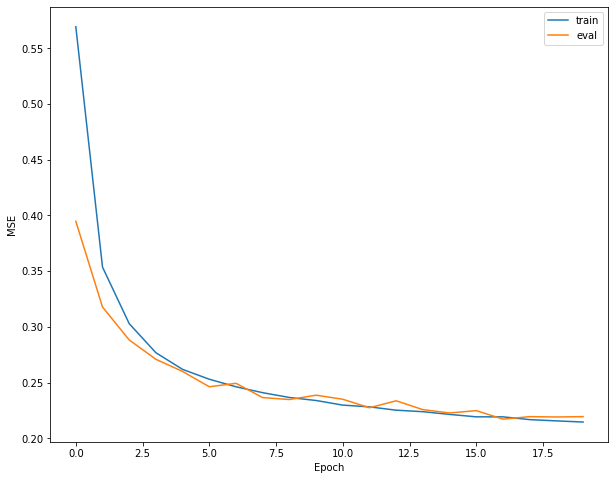

In [0]:
model400 = AutoEncoder(bottleNeckSize=400)
optimizer  = optim.Adam(model400.parameters(), hparams['learning_rate'])
model_log_2 = train_net(train_loader, model400, optimizer, hparams['num_epochs'])

Epoch 1: Train loss 0.5701200439523688, Val loss 0.3790201097726822
Epoch 2: Train loss 0.34475636341913934, Val loss 0.3072106751302878
Epoch 3: Train loss 0.29494759888125105, Val loss 0.28436770662665367
Epoch 4: Train loss 0.2739454017359045, Val loss 0.2692956378062566
Epoch 5: Train loss 0.2588370965267511, Val loss 0.25494455732405186
Epoch 6: Train loss 0.25171689739275405, Val loss 0.24105104617774487
Epoch 7: Train loss 0.24389702789986614, Val loss 0.2401141319423914
Epoch 8: Train loss 0.23928863401503842, Val loss 0.23456522511939207
Epoch 9: Train loss 0.23494371738401765, Val loss 0.2360160412887732
Epoch 10: Train loss 0.23205698218046283, Val loss 0.22975546245773634
Epoch 11: Train loss 0.2281463124158671, Val loss 0.22675977274775505
Epoch 12: Train loss 0.22633491409733691, Val loss 0.22977941359082857
Epoch 13: Train loss 0.22540972445310498, Val loss 0.22478117855886617
Epoch 14: Train loss 0.22200712584994833, Val loss 0.2291622143238783
Epoch 15: Train loss 0.22

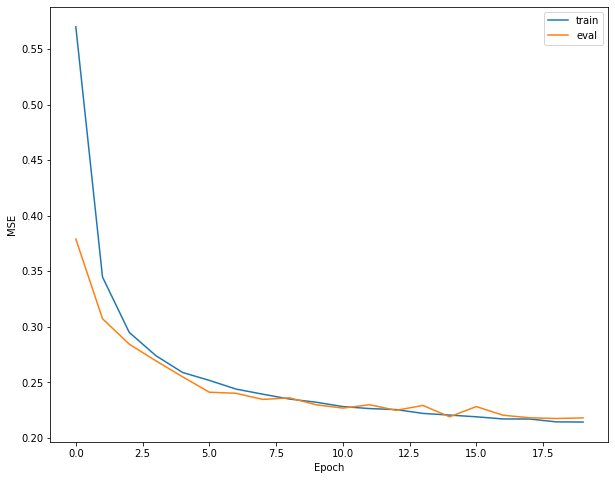

In [0]:
model300 = AutoEncoder(bottleNeckSize=300)
optimizer  = optim.Adam(model300.parameters(), hparams['learning_rate'])
model_log_1 = train_net(train_loader, model300, optimizer, hparams['num_epochs'])

At this point we must save a checkpoint of our model to reuse it in the following exercise:

In [0]:
path='/content/gdrive/My Drive/mnist.pt'
torch.save(model400.state_dict(), path)

In [76]:
weights=torch.load(path)
weights

OrderedDict([('encoding.enc.0.weight', tensor([[[[ 0.1066,  0.0458, -0.1895],
                        [ 0.0763,  0.0773,  0.1861],
                        [ 0.1990,  0.0556,  0.1517]]],
              
              
                      [[[ 0.2458, -0.0549, -0.1217],
                        [-0.0175, -0.2610,  0.0178],
                        [ 0.1531, -0.2322, -0.2822]]],
              
              
                      [[[ 0.0753, -0.2380, -0.0250],
                        [-0.1091, -0.0823,  0.0174],
                        [ 0.1440,  0.1297,  0.1000]]],
              
              
                      [[[ 0.0267,  0.1299, -0.1147],
                        [ 0.1367,  0.0548, -0.2179],
                        [ 0.0074,  0.2623,  0.0849]]],
              
              
                      [[[ 0.0245, -0.1141, -0.0952],
                        [-0.1064,  0.0137, -0.0786],
                        [-0.0978,  0.0570,  0.1765]]],
              
              
                    

- Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.


*Function for counting the # of params of a model:*

In [0]:
def model_params(model):
    # from: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [0]:
#create table
import pandas as pd
data=[('Model 1',model_log_1['te_losses'][-1],model_log_1['ts_loss'],model_params(model300)),
      ('Model 2',model_log_2['te_losses'][-1],model_log_2['ts_loss'],model_params(model400))]
df=pd.DataFrame(data,columns=['model','mse_validation', 'mse_test', 'parameters'])
df

,model,mse_validation,mse_test,parameters
0,Model 1,0.217930,0.218008,3081071
1,Model 2,0.219556,0.219665,3241171


- Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.


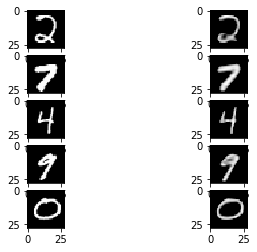

In [0]:
#Choose 5 random images 
device = hparams['device']
iter_ = iter(test_loader)
bimg, blabel = next(iter_)
allimgs=bimg.squeeze(1).data.numpy()
imgs=random.sample(range(0,allimgs.shape[0]), 5)
inimg=[]
outimg=[]
f, axarr = plt.subplots(5, 2)
for k in range(0,5):
  inimg.append(allimgs[imgs[k]])
  inputImage = bimg[imgs[k]].to(device)
  inputImage = inputImage.unsqueeze(0)
  outputImage = model400.forward(inputImage)
  outimg.append(outputImage.squeeze(1).data.numpy())
  axarr[k,0].imshow(allimgs[imgs[k]],cmap='gray')
  axarr[k,1].imshow(outputImage.squeeze(1).data.numpy()[0,:,:],cmap='gray')
plt.show()      





- Generate 5 new images by injecting random values as input to the decoder. Show them.

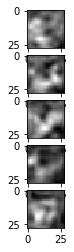

In [0]:
modelx=Decoder(120)
f, axarr = plt.subplots(5)
for k in range(0,5):
  inputImage=torch.randn(1, 120)
  outputImage=modelx.forward(inputImage)
  axarr[k].imshow(outputImage.squeeze(1).data.numpy()[0,:,:],cmap='gray')
plt.show()

# Exercise 2: Transfer Learning
- Select a subset of 100 images and their associated labels from the MNIST training data.
- Select one of the previously trained autoencoders.
- Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
- Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
- Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
- From scratch: train the model on the 100 samples without reusing the decoder weights at all.
- Show the accuracy of the four models on the MNIST test set in a table.


We will start taking a subset of only 100 images



NOTA: Crec que no és necessari separar el small_train_dataset en validation i testing.. Perque podem reutilitzar els datasets de validation i testing del ex1.
D'aquesta manera len(small_data_train) = 100



In [0]:
NUM_TRAIN_IMG = 100  # Number of image to retrain the net
NUM_VALIDATION_IMG = 10
NUM_TEST_IMG = 5
NUM_OUTPUTS = 10      # Number of classes we want to classify
BATCH_SIZE = 1

# Select 100 image of the train_dataset using other method... (90 for training / 10 for validation / 5 test)
small_train_size = NUM_TRAIN_IMG
small_validation_size = NUM_VALIDATION_IMG
small_test_size = NUM_TEST_IMG
other_1_train_data = len(mnist_trainset) - small_train_size
other_2_train_data = other_1_train_data - small_validation_size
other_3_train_data = other_2_train_data - small_test_size

small_train_dataset, other = torch.utils.data.random_split(mnist_trainset, [NUM_TRAIN_IMG, other_1_train_data])
small_test_dataset,other = torch.utils.data.random_split(other, [NUM_VALIDATION_IMG, other_2_train_data]) 
small_validation_dataset,_ = torch.utils.data.random_split(other, [NUM_TEST_IMG, other_3_train_data]) 

small_train_loader = torch.utils.data.DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    small_test_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    small_validation_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True)

## Pre-Training:
Train the classification model using the weights of the autoencoder as initial values for the network.

- Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

At this point we will need to select the first part of the Autoencoder model (Encoder) to use it as a feature_extractor. Then we will stick a densely-connected classifier in order to classify between the classes 0 to 9. (10 classes = 10 outputs)

The method we will use consists in running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier



In [0]:
# Selection of the encoder part
feature_extractor = torch.load('mnist.pt')
feature_extractor

OrderedDict([('encoding.enc.0.weight', tensor([[[[ 0.1066,  0.0458, -0.1895],
                        [ 0.0763,  0.0773,  0.1861],
                        [ 0.1990,  0.0556,  0.1517]]],
              
              
                      [[[ 0.2458, -0.0549, -0.1217],
                        [-0.0175, -0.2610,  0.0178],
                        [ 0.1531, -0.2322, -0.2822]]],
              
              
                      [[[ 0.0753, -0.2380, -0.0250],
                        [-0.1091, -0.0823,  0.0174],
                        [ 0.1440,  0.1297,  0.1000]]],
              
              
                      [[[ 0.0267,  0.1299, -0.1147],
                        [ 0.1367,  0.0548, -0.2179],
                        [ 0.0074,  0.2623,  0.0849]]],
              
              
                      [[[ 0.0245, -0.1141, -0.0952],
                        [-0.1064,  0.0137, -0.0786],
                        [-0.0978,  0.0570,  0.1765]]],
              
              
                    

At this point, we define a dense neural network with 1 hidden layer where the output of this layer will be used as a classification of 10 classes.

TypeError: ignored

In [0]:
classifier = nn.Sequential(
                #model300.encoding,
                Encoder(300), 
                nn.Linear(300,250),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(250,NUM_OUTPUTS),
                nn.ReLU(),
                nn.LogSoftmax()
              )

In [0]:
classif_model_log_1 = train_net(small_train_loader, classifier, optimizer, hparams['num_epochs'])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

Here we will test the classifier using some of our test images.
We will display the input image with the predicted class.

In [0]:
#Code to display img and predicted class

## Fine-tuning: 

- Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
